In [101]:
import os
import glob
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from macrohet import visualise
from matplotlib import rcParams
from scipy.stats import t, zscore

# Starter function

In [108]:
# for drug naming
drug_mapping = {
    'CFZ': 'Clofazimine',
    'PRE': 'Pretomanid',
    'LIN': 'Linezolid',
    'EMB': 'Ethambutol'
}

# Define the log-logistic function
def log_logistic(x, b, c, d, e):
    return c + (d - c) / (1 + np.exp(b * (np.log(x) - np.log(e))))
# Function to fit the model and calculate EC50, EC99, and p-values
def calculate_ec_values(df, concentration_col, growth_col, label, colors, fn, remove_outliers):
    # Filter out zero concentration values to avoid log(0)
    df = df[df[concentration_col] > 0]
    
    if remove_outliers:
        # # Remove outliers using the Z-score method
        # df = df[(np.abs(zscore(df[growth_col])) < 3)]
        # Remove outliers using the IQR method
        Q1 = df[growth_col].quantile(0.25)
        Q3 = df[growth_col].quantile(0.75)
        IQR = Q3 - Q1
        df = df[~((df[growth_col] < (Q1 - 1.5 * IQR)) | (df[growth_col] > (Q3 + 1.5 * IQR)))]


    # Extract the concentration and growth data
    xdata = df[concentration_col].values
    ydata = df[growth_col].values

    # Fit the model
    popt, pcov = curve_fit(log_logistic, xdata, ydata, maxfev=10000)
    perr = np.sqrt(np.diag(pcov))  # Standard errors of the parameters

    # Calculate t-statistics for each parameter
    t_values = popt / perr

    # Degrees of freedom
    dof = max(0, len(xdata) - len(popt))

    # Calculate p-values for each parameter
    p_values = [2 * (1 - t.cdf(np.abs(t_val), dof)) for t_val in t_values]

    # Predict values for plotting
    x_fit = np.linspace(min(xdata), max(xdata), 100)
    y_fit = log_logistic(x_fit, *popt)

    # Calculate EC50 (inflection point) and EC99
    ec50 = popt[3]
    ec50_error = np.sqrt(pcov[3, 3])  # Standard error of EC50
    ec99 = ec50 * np.exp(np.log(99) / popt[0])
    ec99_error = ec99 * np.sqrt((np.log(99) / popt[0])**2 * (pcov[0, 0] / popt[0]**2) + (pcov[3, 3] / popt[3]**2))  # Propagated error

    # Calculate 95% confidence intervals for EC50
    alpha = 0.05  # Significance level
    t_critical = t.ppf(1 - alpha / 2, dof)
    ec50_conf_interval = (ec50 - t_critical * ec50_error, ec50 + t_critical * ec50_error)

    # Prepare legend information
    legend_info = (f"EC50: {ec50:.2f} ± {ec50_error:.2f}\n"
                   f"EC99: {ec99:.2f} ± {ec99_error:.2f}\n"
                   f"P-value on EC50: {p_values[3]:.2f}")

    # Plot the data and the fitted curve
    plt.figure()
    sns.set(style="whitegrid")
    
    # Use Nimbus Sans font
    rcParams['font.family'] = 'Nimbus Sans'

    # Scatter plot for the data
    sns.scatterplot(x=xdata, y=ydata, label='Data', color=colors[-1], edgecolor="w", s=100)

    # Line plot for the fitted curve
    sns.lineplot(x=x_fit, y=y_fit, label='Fitted curve', color=colors[0])

    plt.xlabel(concentration_col)
    plt.ylabel(growth_col)
    plt.title(f'{label} Dose-Response Curve')
    plt.xscale('log')
    plt.yscale('linear')
    sns.despine(offset=10)

    # Add legend with EC50 and EC99 information
    plt.legend(title=legend_info, loc='upper left', bbox_to_anchor=(1, 1))
    
    # Save the plot
    output_path = os.path.join('/mnt/NEMO/home/shared/Shared - Baptiste Pradel/MacroHET/2024-06-07 Analysis-EC50-99 r/nathan_calcs', os.path.basename(fn).replace('.xlsx', '.png'))
    if remove_outliers:
        output_path = os.path.join('/mnt/NEMO/home/shared/Shared - Baptiste Pradel/MacroHET/2024-06-07 Analysis-EC50-99 r/nathan_calcs/outliers_removed', os.path.basename(fn).replace('.xlsx', '_outliers_removed.png'))

    plt.savefig(output_path, dpi=314, bbox_inches='tight')
    plt.show()

    return {'EC50': (ec50, ec50_error, ec50_conf_interval), 'EC99': (ec99, ec99_error), 'p-values': p_values}


# Find files

In [85]:
base_dir = '/mnt/NEMO/home/shared/Shared - Baptiste Pradel/MacroHET/2024-06-07 Analysis-EC50-99 r/'

output_dir = os.path.join(base_dir, 'nathan_calcs')
os.makedirs(output_dir, exist_ok=True)

# For Pretomanid WT
fns = glob.glob('/mnt/NEMO/home/shared/Shared - Baptiste Pradel/MacroHET/2024-06-07 Analysis-EC50-99 r/*-MtbWT.xlsx')
fns = [fn for fn in fns if '$' not in fn]
print([f'{i}:{os.path.basename(fn)}' for i, fn in enumerate(fns)])

['0:Pretomanid-MtbWT.xlsx', '1:Ethambutol-MtbWT.xlsx', '2:Clofazimine-MtbWT.xlsx', '3:Linezolid-MtbWT.xlsx']


# Iterate over fns and plot all data

/tmp/ipykernel_18535/2406266173.py:3: RuntimeWarning: invalid value encountered in log
  return c + (d - c) / (1 + np.exp(b * (np.log(x) - np.log(e))))


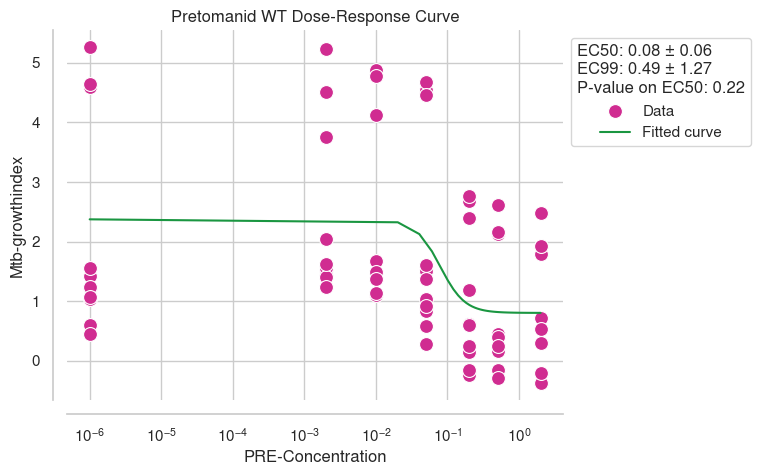

/tmp/ipykernel_18535/2406266173.py:3: RuntimeWarning: invalid value encountered in log
  return c + (d - c) / (1 + np.exp(b * (np.log(x) - np.log(e))))


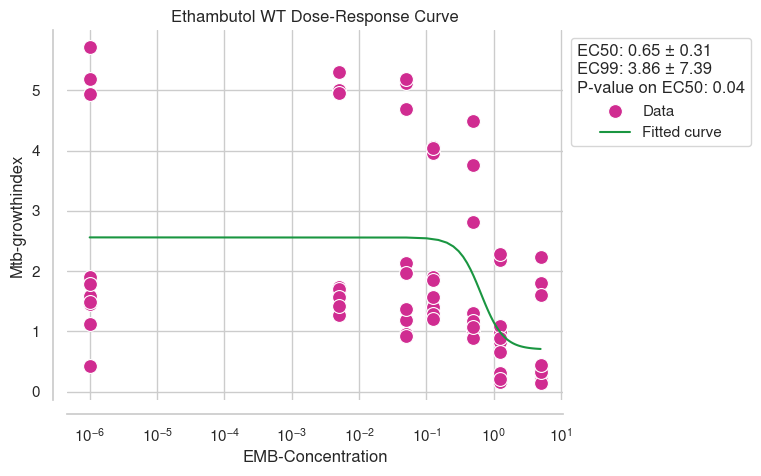

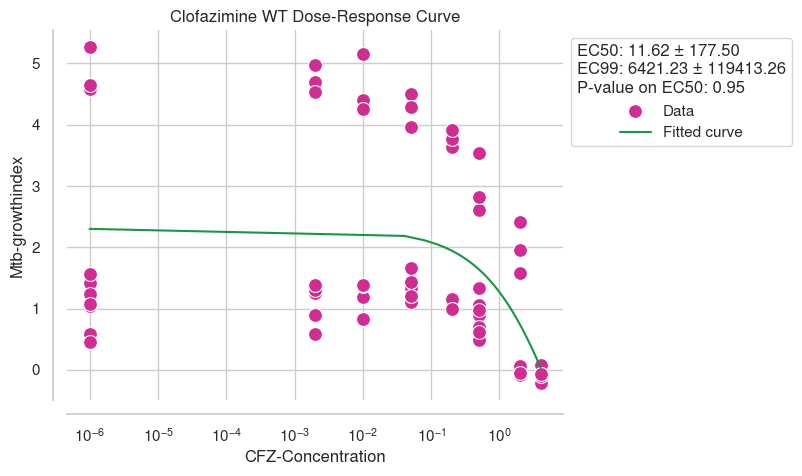

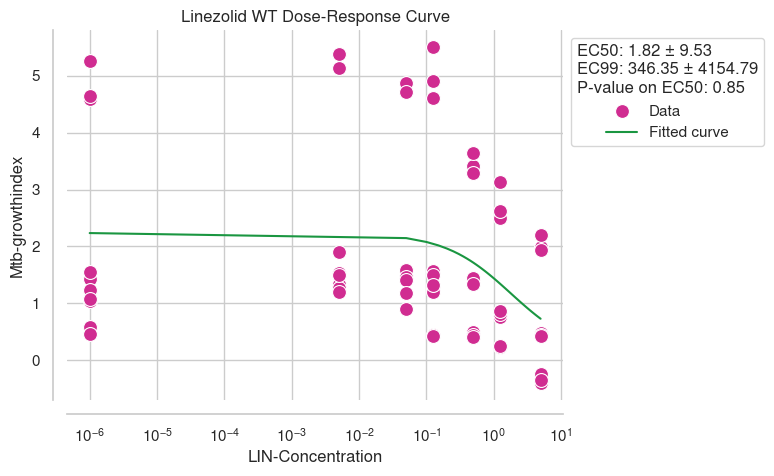

In [100]:
for fn in fns:
    df = pd.read_excel(fn)
    col_name = df.columns[0]

    # Ensure no zero values in the concentration to avoid log(0)
    df[col_name] = df[col_name].replace(0, 1e-6)
    
    # Calculate EC50 and EC99 for the provided data
    ec_values = calculate_ec_values(df, col_name, 'Mtb-growthindex', f'{drug_mapping[col_name[0:3]]} WT', expanded_piyg, fn)

# Iterate over fns and plot cleaned data

/tmp/ipykernel_18535/1392398315.py:11: RuntimeWarning: invalid value encountered in log
  return c + (d - c) / (1 + np.exp(b * (np.log(x) - np.log(e))))


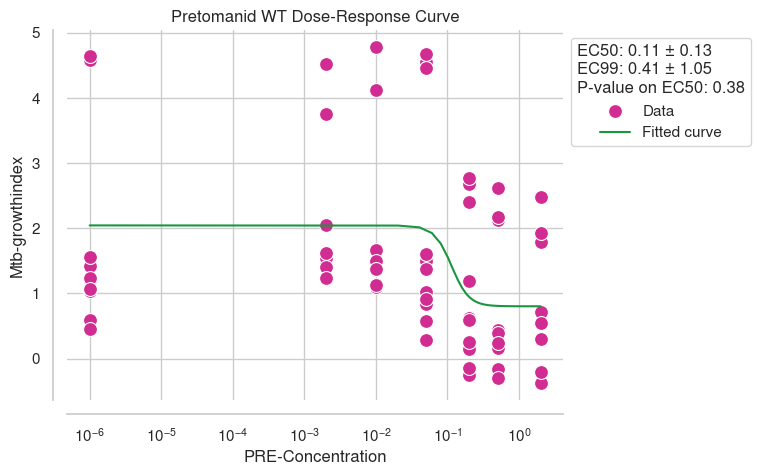

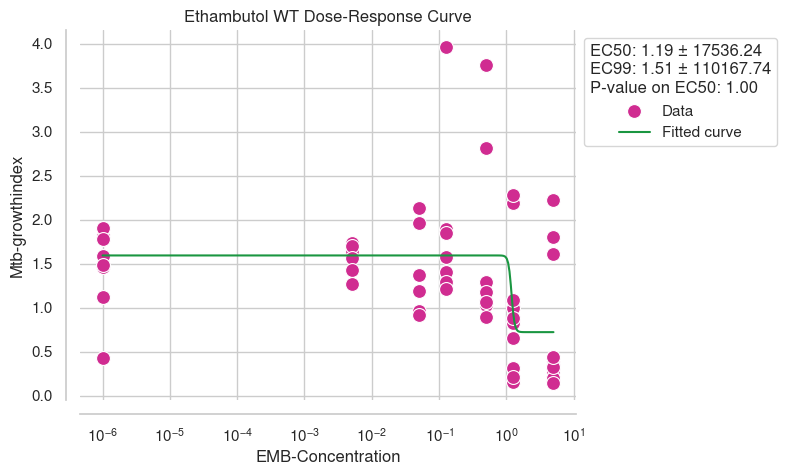

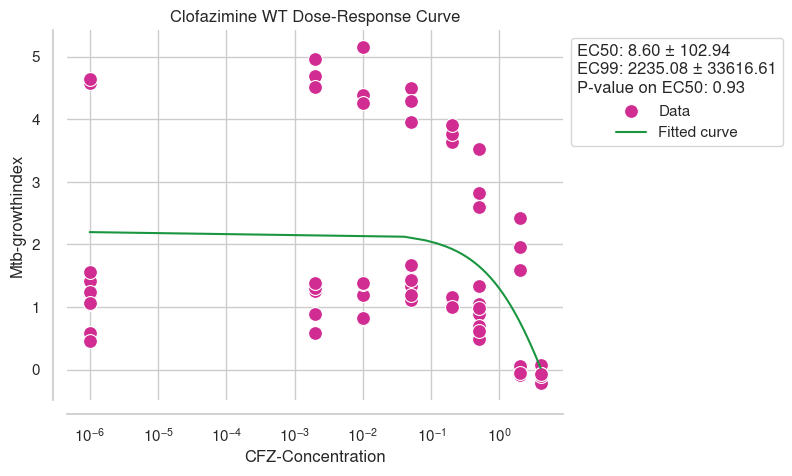

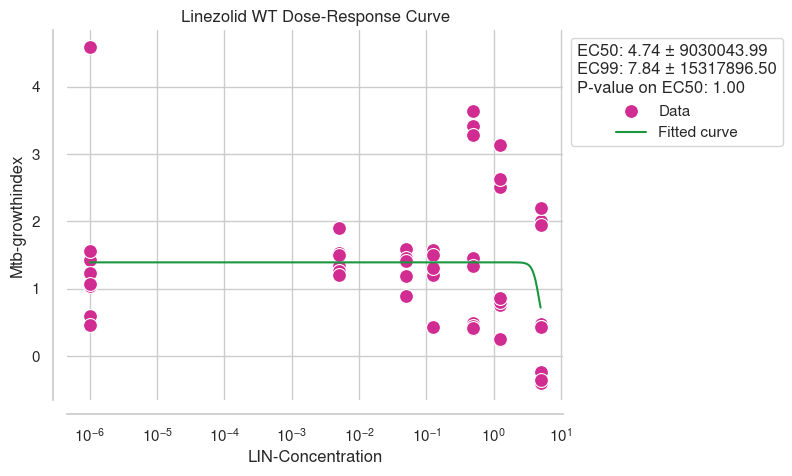

In [109]:
for fn in fns:
    df = pd.read_excel(fn)
    col_name = df.columns[0]

    # Ensure no zero values in the concentration to avoid log(0)
    df[col_name] = df[col_name].replace(0, 1e-6)
    
    # Calculate EC50 and EC99 for the provided data
    ec_values = calculate_ec_values(df, col_name, 'Mtb-growthindex', f'{drug_mapping[col_name[0:3]]} WT', expanded_piyg, fn, True)